# Average distance per activity destination

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.spatial.distance import euclidean
from scipy.spatial import distance
from matplotlib.patches import Patch
import warnings
import numpy as np
import geopandas as gpd

In [9]:
def add_trip_euclidean_distance(df):
    # Read PC4 geometries
    shapefile_path = "../../../DHZW_shapefiles/data/processed/shapefiles/centroids_PC4_NL_shp/centroids_PC4_NL_shp.shp"
    shapefile_df = gpd.read_file(shapefile_path)

    # Merge the geometry postal code coordinates with the trips departure and arrival postcodes from the dataframe
    df = pd.merge(df, shapefile_df, left_on='disp_start_PC4', right_on='PC4', how='left')
    
    df = df.rename(columns={'geometry': 'geometry_start'})
    df = df.drop('PC4', axis=1)
            
    df = pd.merge(df, shapefile_df, left_on='disp_arrival_PC4', right_on='PC4', how='left')
    
    df = df.rename(columns={'geometry': 'geometry_arrival'})
    df = df.drop('PC4', axis=1)
        
    # Merge the geometry postal code coordinates with the trips home postcode
    df = pd.merge(df, shapefile_df, left_on='hh_PC4', right_on='PC4', how='left')
    
    df = df.rename(columns={'geometry': 'geometry_home'})
    df = df.drop('PC4', axis=1)
    
    # Calculate Euclidean distance for each trip
    df['euclidean_distance'] = [distance.euclidean(p1, p2) for p1, p2 in zip(df['geometry_start'], df['geometry_arrival'])]
    df['euclidean_distance'] = df['euclidean_distance'] * 100

    # Calculate Euclidean distance for each trip from home to destination
    df['euclidean_distance_from_home'] = [distance.euclidean(p1, p2) for p1, p2 in zip(df['geometry_home'], df['geometry_arrival'])]
    df['euclidean_distance_from_home'] = df['euclidean_distance_from_home'] * 100
    
    return(df)

### Import

In [10]:
# Read DHZW trips

#os.chdir('C:/Users/6997619/Documents/GitHub projects/DHZW_assign_location/data/processed')
df_ODiN = pd.read_csv("../../data/processed/displacements_DHZW.csv")

print('n ODiN trips: ' + str(len(df_ODiN)))
print('n ODiN participants: ' + str(len(pd.unique(df_ODiN['agent_ID']))))

df_synthetic = pd.read_csv("../../data/processed/analysis/synthetic_trips.csv")
print('n synthetic trips: ' + str(len(df_synthetic)))
print('n synthetic agents: ' + str(len(pd.unique(df_synthetic['agent_ID']))))

n ODiN trips: 1333
n ODiN participants: 638
n synthetic trips: 867442
n synthetic agents: 84434


In [11]:
# add previous activity information for ODiN

df_ODiN = df_ODiN.sort_values(by='disp_ID')

# Add a new column 'previous_activity' to store the previous activity for each trip
df_ODiN['previous_activity'] = df_ODiN.groupby('agent_ID')['disp_activity'].shift()
df_ODiN['previous_activity'].fillna('HOME', inplace=True)

In [12]:
df_ODiN = add_trip_euclidean_distance(df_ODiN)
df_synthetic = add_trip_euclidean_distance(df_synthetic)

C:\Users\6997619\Anaconda3\envs\dhzw_env\lib\site-packages\scipy\spatial\distance.py:461: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  u = _validate_vector(u)
C:\Users\6997619\Anaconda3\envs\dhzw_env\lib\site-packages\scipy\spatial\distance.py:462: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  v = _validate_vector(v)
C:\Users\6997619\Anaconda3\envs\dhzw_env\lib\site-packages\scipy\spatial\distance.py:461: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  u = _validate_vector(u)
C:\Users\6997619\Anaconda3\envs\dhzw_env\lib\site-packages\scipy\spatial\distance.py:462: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.

### Calculate Euclidean Distance for trips and from home to destination

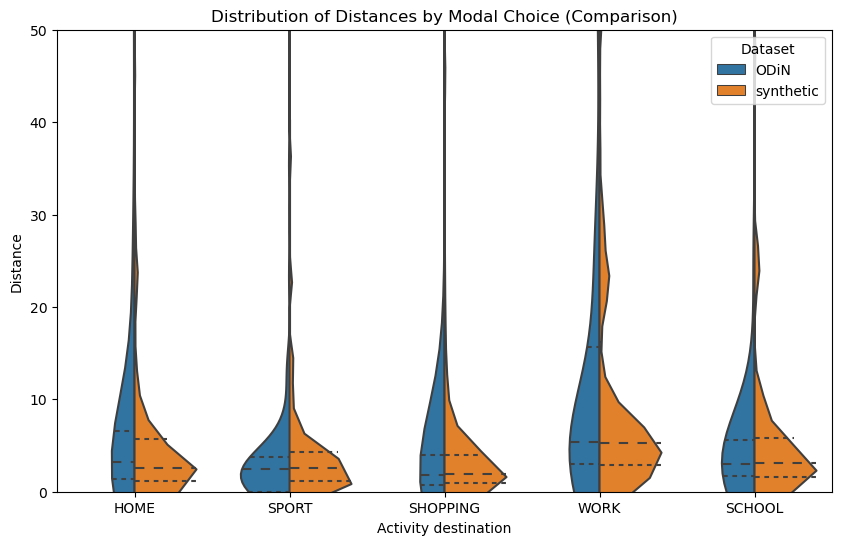

In [13]:
df1 = df_ODiN[['disp_activity', 'euclidean_distance']]
df2 = df_synthetic[['disp_activity', 'euclidean_distance']]

# Merge the datasets
df_merged = pd.concat([df1, df2], keys=['ODiN', 'synthetic'])

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Violin plot
violinplot = sns.violinplot(data=df_merged, x='disp_activity', y='euclidean_distance', hue=df_merged.index.get_level_values(0), split=True, inner="quartile", ax=ax)

# Customize plot
ax.set_xlabel('Activity destination')
ax.set_ylabel('Distance')
ax.set_title('Distribution of Distances by Modal Choice (Comparison)')
ax.set_ylim(0, 50)  # Adjust 'upper_limit' as needed

# Display plot
plt.legend(title='Dataset')
plt.show()

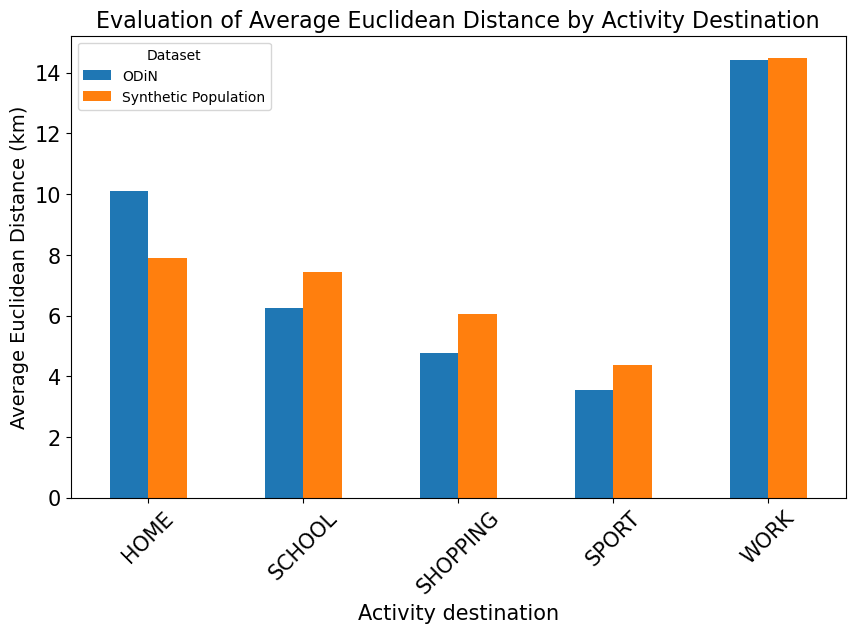

In [19]:
df1 = df_ODiN[['disp_activity', 'euclidean_distance']]
df2 = df_synthetic[['disp_activity', 'euclidean_distance']]

# Merge the datasets
df_merged = pd.concat([df1, df2], keys=['ODiN', 'Synthetic Population'])

# Calculate the average distance for each activity within each dataset
averages = df_merged.groupby(['disp_activity', df_merged.index.get_level_values(0)])['euclidean_distance'].mean()
averages = averages.unstack()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

averages.plot(kind='bar', ax=ax)

# Customize plot
ax.set_xlabel('Activity destination', fontsize=15)  # Increase the font size
ax.set_ylabel('Average Euclidean Distance (km)', fontsize=14)  # Increase the font size
ax.set_title('Evaluation of Average Euclidean Distance by Activity Destination', fontsize=16)  # Increase the font size

# Set the font size for tick labels
ax.tick_params(axis='x', labelsize=15)  # Increase the font size for x-axis tick labels
ax.tick_params(axis='y', labelsize=15)  # Increase the font size for y-axis tick labels

# Display legend
plt.legend(title='Dataset', fontsize=15)  # Increase the font size for legend

plt.xticks(rotation=45)

# Display plot
plt.legend(title='Dataset')
plt.show()

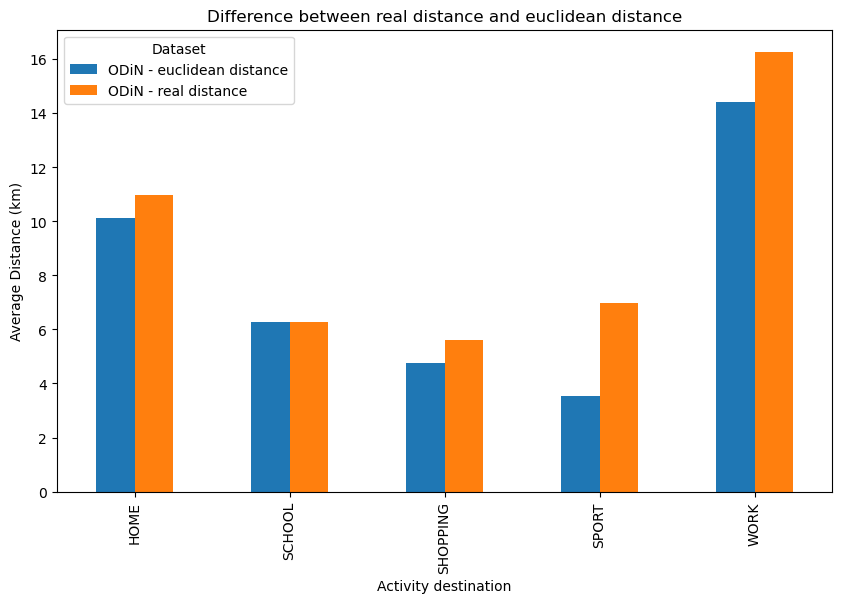

In [20]:
df1 = df_ODiN[['disp_activity', 'distance']]
df2 = df_ODiN[['disp_activity', 'euclidean_distance']]
df2 = df2.rename(columns={'euclidean_distance': 'distance'})

# Merge the datasets
df_merged = pd.concat([df1, df2], keys=['ODiN - real distance', 'ODiN - euclidean distance'])

# Calculate the average distance for each activity within each dataset
averages = df_merged.groupby(['disp_activity', df_merged.index.get_level_values(0)])['distance'].mean()
averages = averages.unstack()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

averages.plot(kind='bar', ax=ax)

# Customize plot
ax.set_xlabel('Activity destination')
ax.set_ylabel('Average Distance (km)')
ax.set_title('Difference between real distance and euclidean distance')

# Display plot
plt.legend(title='Dataset')
plt.show()

# Focus on work trips

In [21]:
# Filter work trips

df_ODiN = df_ODiN[df_ODiN['disp_activity'] == 'WORK']
print('n ODiN work trips: ' + str(len(df_ODiN)))
print('n ODiN work participants: ' + str(len(pd.unique(df_ODiN['agent_ID']))))

print('\n')

df_synthetic = df_synthetic[df_synthetic['disp_activity'] == 'WORK']
print('n synthetic work trips: ' + str(len(df_synthetic)))
print('n synthetic work agents: ' + str(len(pd.unique(df_synthetic['agent_ID']))))

n ODiN work trips: 258
n ODiN work participants: 245


n synthetic work trips: 141093
n synthetic work agents: 56475


In [22]:
def postcodes_float_to_string(df):
    df['disp_arrival_PC4'] = df['disp_arrival_PC4'].astype(int)
    df['disp_arrival_PC4'] = df['disp_arrival_PC4'].astype(str)

    df['disp_start_PC4'] = df['disp_start_PC4'].astype(int)
    df['disp_start_PC4'] = df['disp_start_PC4'].astype(str)

    df['hh_PC4'] = df['hh_PC4'].astype(int)
    df['hh_PC4'] = df['hh_PC4'].astype(str)
    
    return(df)

In [23]:
df_ODiN = postcodes_float_to_string(df_ODiN)
df_synthetic = postcodes_float_to_string(df_synthetic)

# Distribution of previous activity to work

In [24]:
def distr_prev_activity(df, title_label):
    frequency_distribution = df['previous_activity'].value_counts()
    
    # Sort the frequency distribution by index (alphabetical order)
    frequency_distribution = frequency_distribution.sort_index()

    # Create a bar plot
    frequency_distribution.plot(kind='bar')

    # Set plot labels and title
    plt.xlabel('Previous Activity')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
    plt.title('Frequency Distribution of Previous Activity for Work Trips - ' + title_label)

    # Display the plot
    plt.show()

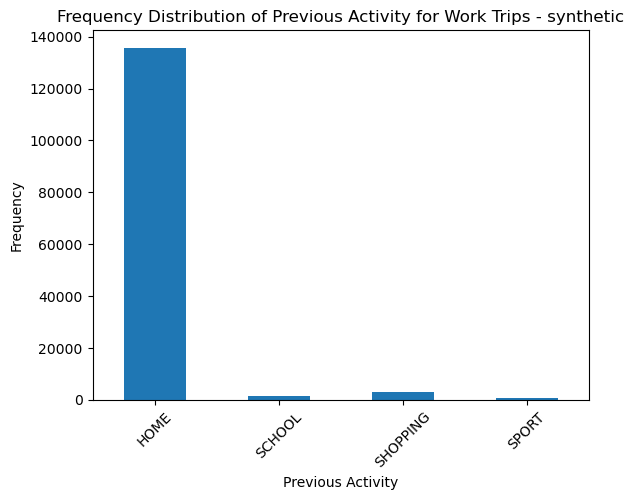

In [25]:
distr_prev_activity(df_synthetic, 'synthetic')

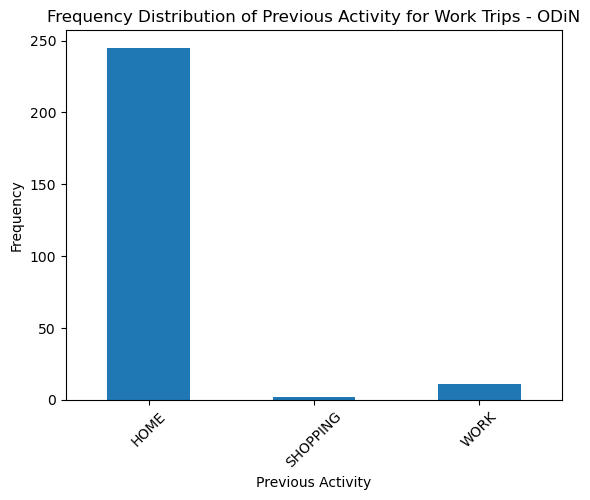

In [26]:
distr_prev_activity(df_ODiN, 'ODiN')

### --> Individuals mostly go to work from home

# Average Trips per Person

In [27]:
# Create a dataframe with agent IDs and average trips
def average_trips_per_agent(df):
    return df.groupby('agent_ID').size().mean()

def sd_trips_per_agent(df):
    return df.groupby('agent_ID').size().std()

def average_n_trips_per_person(df, title_label):
    # Filter week days
    df_monday = df[df['day_of_week'] == 1]
    df_tuesday = df[df['day_of_week'] == 2]
    df_wednesday = df[df['day_of_week'] == 3]
    df_thursday = df[df['day_of_week'] == 4]
    df_friday = df[df['day_of_week'] == 5]
    df_saturday = df[df['day_of_week'] == 6]
    df_sunday = df[df['day_of_week'] == 7]

    # Calculate average trips for each dataset
    avg_monday = average_trips_per_agent(df_monday)
    avg_tuesday = average_trips_per_agent(df_tuesday)
    avg_wednesday = average_trips_per_agent(df_wednesday)
    avg_thursday = average_trips_per_agent(df_thursday)
    avg_friday = average_trips_per_agent(df_friday)
    avg_saturday = average_trips_per_agent(df_saturday)
    avg_sunday = average_trips_per_agent(df_sunday)

    # Calculate standard deviation for each dataset
    sd_monday = sd_trips_per_agent(df_monday)
    sd_tuesday = sd_trips_per_agent(df_tuesday)
    sd_wednesday = sd_trips_per_agent(df_wednesday)
    sd_thursday = sd_trips_per_agent(df_thursday)
    sd_friday = sd_trips_per_agent(df_friday)
    sd_saturday = sd_trips_per_agent(df_saturday)
    sd_sunday = sd_trips_per_agent(df_sunday)

    # Create a dataframe with mean and standard deviation values for each dataset
    df_combined = pd.DataFrame({
        'Dataset': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        'average': [avg_monday, avg_tuesday, avg_wednesday, avg_thursday, avg_friday, avg_saturday, avg_sunday],
        'sd': [sd_monday, sd_tuesday, sd_wednesday, sd_thursday, sd_friday, sd_saturday, sd_sunday]
    })

    # plot
    sns.barplot(x='Dataset', y='average', data=df_combined, color='cyan', yerr=df_combined['sd'])
    plt.ylabel("Average Number of Trips per Person")
    plt.xlabel("Day")
    plt.title("Average Number of Work Trips per Person - " + title_label)
    plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

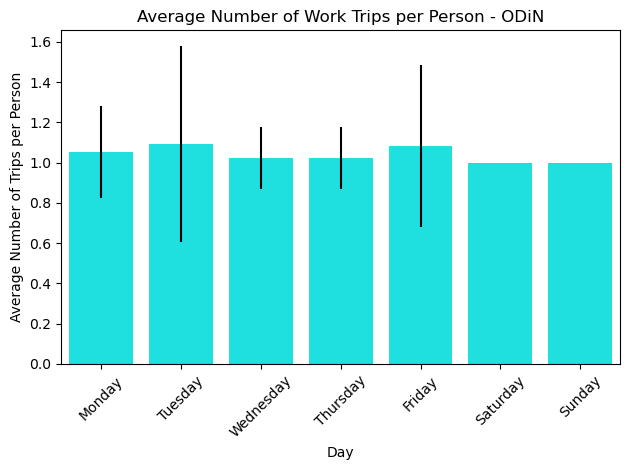

In [28]:
average_n_trips_per_person(df_ODiN, 'ODiN')

In [29]:
# people take more days off on monday and friday. on the weekend the few ones that work all work once per day

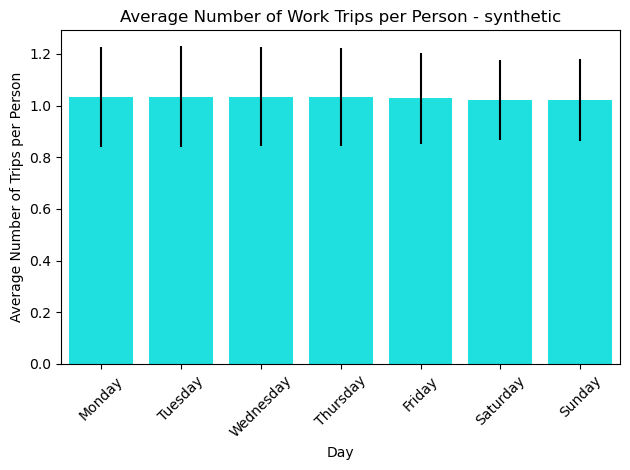

In [30]:
average_n_trips_per_person(df_synthetic, 'synthetic')

# Number of Trips per Day

In [31]:
def average_n_trips_per_day(df, title_label):
    # Filter week days
    df_monday = df[df['day_of_week'] == 1]
    df_tuesday = df[df['day_of_week'] == 2]
    df_wednesday = df[df['day_of_week'] == 3]
    df_thursday = df[df['day_of_week'] == 4]
    df_friday = df[df['day_of_week'] == 5]
    df_saturday = df[df['day_of_week'] == 6]
    df_sunday = df[df['day_of_week'] == 7]
    
    n_trips_per_day = [len(df_monday), len(df_tuesday), len(df_wednesday), len(df_thursday), len(df_friday), len(df_saturday), len(df_sunday)]

    df_combined = pd.DataFrame({
        'Dataset': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        'Number_of_Trips': n_trips_per_day
    })

    # plot
    sns.set_palette("deep")
    sns.barplot(x='Dataset', y='Number_of_Trips', data=df_combined, color='cyan')
    plt.xlabel("Day")
    plt.ylabel("Number of Trips")
    plt.title("Number of Work Trips per Day - " + title_label)
    plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

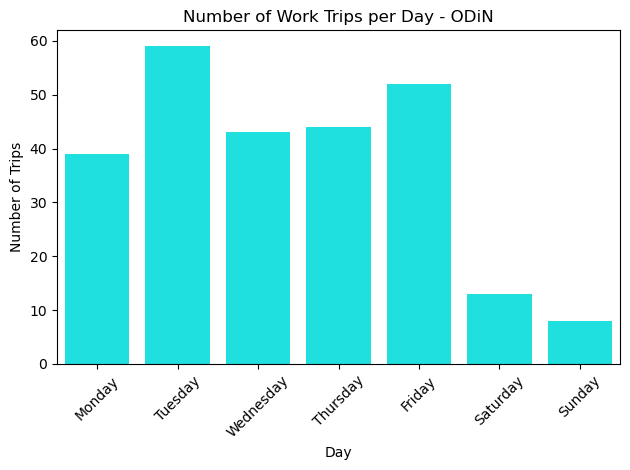

In [32]:
average_n_trips_per_day(df_ODiN, 'ODiN')

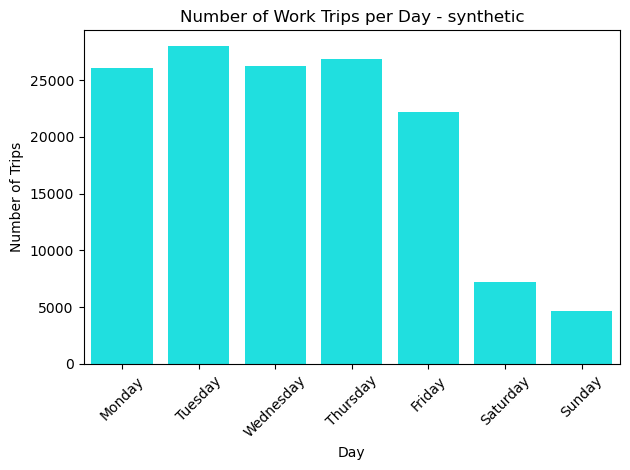

In [33]:
average_n_trips_per_day(df_synthetic, 'synthetic')

# Average Euclidean Distance per Day

In [34]:
def average_n_trips_per_day(df, title_label):
    # Filter week days
    df_monday = df[df['day_of_week'] == 1]
    df_tuesday = df[df['day_of_week'] == 2]
    df_wednesday = df[df['day_of_week'] == 3]
    df_thursday = df[df['day_of_week'] == 4]
    df_friday = df[df['day_of_week'] == 5]
    df_saturday = df[df['day_of_week'] == 6]
    df_sunday = df[df['day_of_week'] == 7]
    
    mean_distance_per_day = [
        df['euclidean_distance'].mean(),
        df_monday['euclidean_distance'].mean(),
        df_tuesday['euclidean_distance'].mean(),
        df_wednesday['euclidean_distance'].mean(),
        df_thursday['euclidean_distance'].mean(),
        df_friday['euclidean_distance'].mean(),
        df_saturday['euclidean_distance'].mean(),
        df_sunday['euclidean_distance'].mean()
    ]

    df_combined = pd.DataFrame({
        'Dataset': ['Entire week', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        'Average_Distance': mean_distance_per_day
    })

    # plot
    sns.set_palette("deep")
    sns.barplot(x='Dataset', y='Average_Distance', data=df_combined, color='cyan')
    plt.xlabel("Day")
    plt.ylabel("Average Euclidean Distance (km)")
    plt.title("Average Euclidean Distance per Day of Work Trips - " + title_label)
    plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

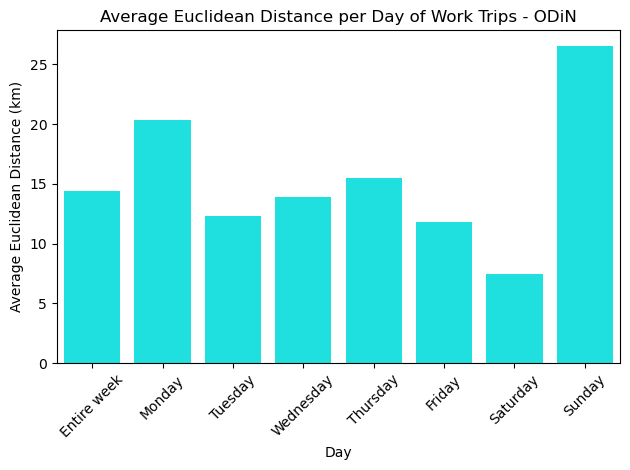

In [35]:
average_n_trips_per_day(df_ODiN, 'ODiN')

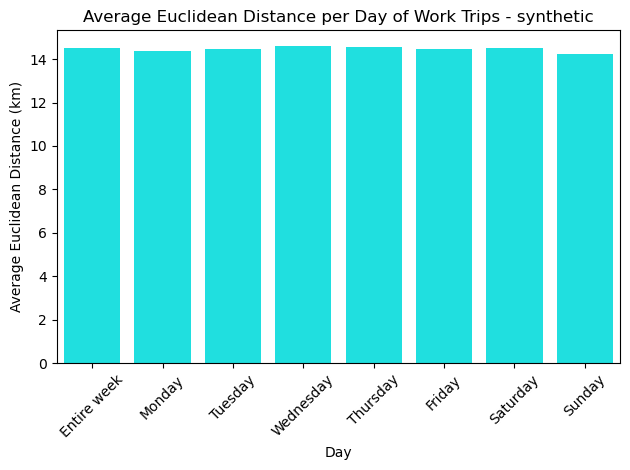

In [36]:
average_n_trips_per_day(df_synthetic, 'synthetic')

# Average Euclidean Distance per Person per Day

In [37]:
def average_distance_per_agent(df):
    average_distance_per_agent = df.groupby('agent_ID')['euclidean_distance'].mean().mean()
    return average_distance_per_agent

def average_distance_per_person_per_day(df, title_label):
    # Filter week days
    df_monday = df[df['day_of_week'] == 1]
    df_tuesday = df[df['day_of_week'] == 2]
    df_wednesday = df[df['day_of_week'] == 3]
    df_thursday = df[df['day_of_week'] == 4]
    df_friday = df[df['day_of_week'] == 5]
    df_saturday = df[df['day_of_week'] == 6]
    df_sunday = df[df['day_of_week'] == 7]
    
    average_distance_per_person = [
        average_distance_per_agent(df),
        average_distance_per_agent(df_monday),
        average_distance_per_agent(df_tuesday),
        average_distance_per_agent(df_wednesday),
        average_distance_per_agent(df_thursday),
        average_distance_per_agent(df_friday),
        average_distance_per_agent(df_saturday),
        average_distance_per_agent(df_sunday)
    ]

    # Step 3: Create a dataframe with the average distance per person
    df_combined = pd.DataFrame({
        'Dataset': ['Entire week', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        'Average_Distance': average_distance_per_person
    })

    # Step 4: Create bar plot using seaborn (color: cyan)
    sns.set_palette("deep")
    sns.barplot(x='Dataset', y='Average_Distance', data=df_combined, color='cyan')
    plt.xlabel("Day")
    plt.ylabel("Average Euclidean Distance per Person (km)")
    plt.title("Average Euclidean Distance per Person per Day of Work Trips - " + title_label)
    plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

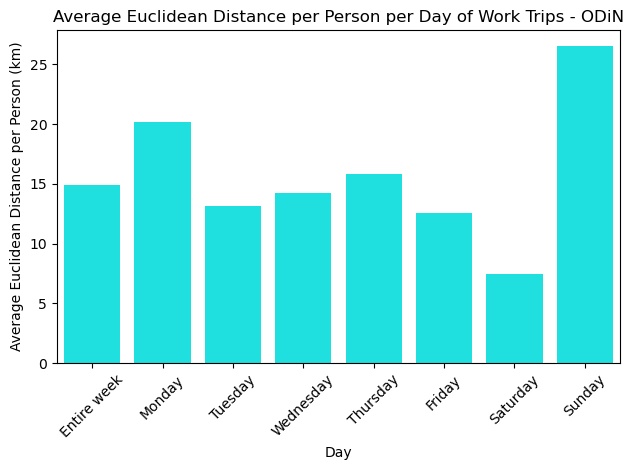

In [38]:
average_distance_per_person_per_day(df_ODiN, 'ODiN')

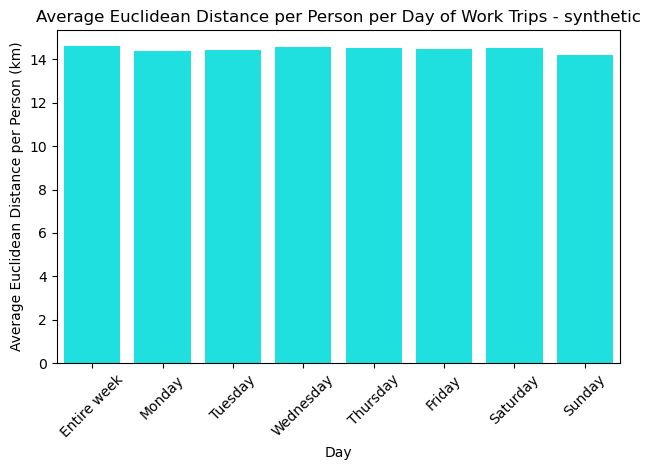

In [39]:
average_distance_per_person_per_day(df_synthetic, 'synthetic')

# Postcode Destination Analysis

In [40]:
# Read the CSV file with postcodes
csv_file = pd.read_csv("../../../DHZW_shapefiles/data/codes/DHZW_PC4_codes.csv", header=None)
postcodes_DHZW = csv_file.iloc[:, 0].tolist()
postcodes_DHZW = list(map(str, postcodes_DHZW))

print('Postcodes of DHZW:')
print(postcodes_DHZW)

Postcodes of DHZW:
['2531', '2532', '2533', '2541', '2542', '2543', '2544', '2545', '2546']


In [41]:
# Distribution of home postcodes over work trips
home_postcode_distribution = df_ODiN['hh_PC4'].value_counts()
home_postcode_distribution

2545    57
2544    37
2531    33
2546    33
2542    27
2541    22
2543    21
2532    16
2533    12
Name: hh_PC4, dtype: int64

In [42]:
# Filter trips with origin postcode

print('BEFORE')
print('n ODiN trips: ' + str(len(df_ODiN)))
print('n ODiN participants: ' + str(len(pd.unique(df_ODiN['agent_ID']))))
print('n synthetic trips: ' + str(len(df_synthetic)))
print('n synthetic agents: ' + str(len(pd.unique(df_synthetic['agent_ID']))))

postcode_analysis = '2545'
df_ODiN_filtered = df_ODiN[df_ODiN['hh_PC4'] == postcode_analysis]
df_synthetic_filtered = df_synthetic[df_synthetic['hh_PC4'] == postcode_analysis]

print('AFTER')
print('n ODiN trips: ' + str(len(df_ODiN_filtered)))
print('n ODiN participants: ' + str(len(pd.unique(df_ODiN_filtered['agent_ID']))))
print('n synthetic trips: ' + str(len(df_synthetic_filtered)))
print('n synthetic agents: ' + str(len(pd.unique(df_synthetic_filtered['agent_ID']))))

BEFORE
n ODiN trips: 258
n ODiN participants: 245
n synthetic trips: 141093
n synthetic agents: 56475
AFTER
n ODiN trips: 57
n ODiN participants: 50
n synthetic trips: 22853
n synthetic agents: 9100


In [62]:
def destination_distribution(df_ODiN, df_synthetic):
    # Count the occurrences of each destination postcode for dataset 1
    destination_counts_ODiN = df_ODiN['disp_arrival_PC4'].value_counts()
    destination_counts_ODiN = (destination_counts_ODiN / destination_counts_ODiN.sum()) * 100
    
    print('n postcodes in ODiN: ' + str(len(destination_counts_ODiN)))

    # Count the occurrences of each destination postcode for dataset 2
    destination_counts_synthetic = df_synthetic['disp_arrival_PC4'].value_counts()
    destination_counts_synthetic = (destination_counts_synthetic / destination_counts_synthetic.sum()) * 100
    
    print('n postcodes in synthetic: ' + str(len(destination_counts_synthetic)))

    # Get the unique postcodes from both datasets
    postcodes = set(destination_counts_ODiN.index) | set(destination_counts_synthetic.index)

    # Sort the postcodes alphabetically
    sorted_postcodes = sorted(postcodes)
    
    destination_counts_ODiN = destination_counts_ODiN.reindex(sorted_postcodes, fill_value=0)
    destination_counts_synthetic = destination_counts_synthetic.reindex(sorted_postcodes, fill_value=0)

    # Plot the destination distribution as a bar plot
    plt.figure(figsize=(10, 6))
    
    # Bar width and separation for two datasets
    bar_width = 0.3
    bar_separation = 0

    # Calculate the positions for the bars for dataset 1
    positions1 = np.arange(len(sorted_postcodes))
    
    # Plot bars for dataset 1
    plt.bar(positions1, destination_counts_ODiN.loc[sorted_postcodes],
            bar_width, color='blue', label='ODiN')

    # Calculate the positions for the bars for dataset 2
    positions2 = positions1 + bar_width + bar_separation
    
    # Plot bars for dataset 2
    plt.bar(positions2, destination_counts_synthetic.loc[sorted_postcodes],
            bar_width, color='orange', label='synthetic')

    # Set x-axis tick positions and labels
    plt.xticks(positions1 + bar_width / 2, sorted_postcodes, rotation=45, ha='right')

    # Customize plot
    ax = plt.gca()  # Get the current axes object
    ax.set_xlabel('Destination Postcode', fontsize=15)
    ax.set_ylabel('Proportion of Work Trips (%)', fontsize=14)
    ax.set_title('Postcode PC4 Destination Distribution of Work Trips or residents in PC4 '+postcode_analysis, fontsize=16)

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=15)

    plt.legend(title='Dataset', fontsize=15)
    
    plt.show()

n postcodes in ODiN: 37
n postcodes in synthetic: 37


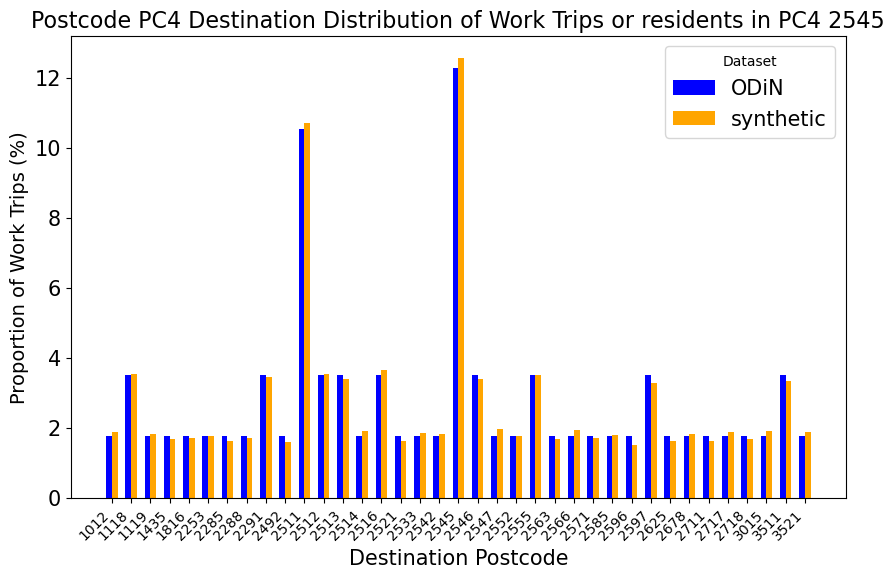

In [63]:
destination_distribution(df_ODiN_filtered, df_synthetic_filtered)

# Distance destination

In [36]:
# Merge with shapefile to get coordinates of each postcode
shapefile_path = "../../DHZW_shapefiles/data/processed/shapefiles/centroids_PC4_NL_shp/centroids_PC4_NL_shp.shp"
shapefile = gpd.read_file(shapefile_path)

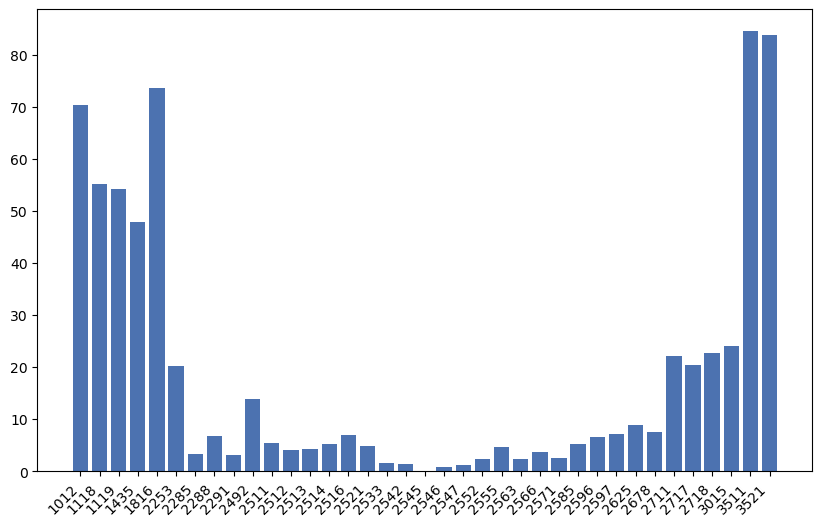

In [37]:
def distance_distribution(df_filtered, title_label):
    # Create a dataframe to store the postcodes and distances
    df_distances = df_filtered[['disp_arrival_PC4', 'euclidean_distance_from_home']]
    df_distances = df_distances.drop_duplicates('disp_arrival_PC4')
        
    df_distances = pd.DataFrame(df_distances)
            
    df_distances = df_distances.sort_values('disp_arrival_PC4')
        
    # Plotting the bar plot
    
    plt.figure(figsize=(10, 6))

    plt.bar(df_distances['disp_arrival_PC4'], df_distances['euclidean_distance_from_home'])
    
    plt.xticks(rotation=45, ha='right')


distance_distribution(df_ODiN_filtered, 'ODiN')

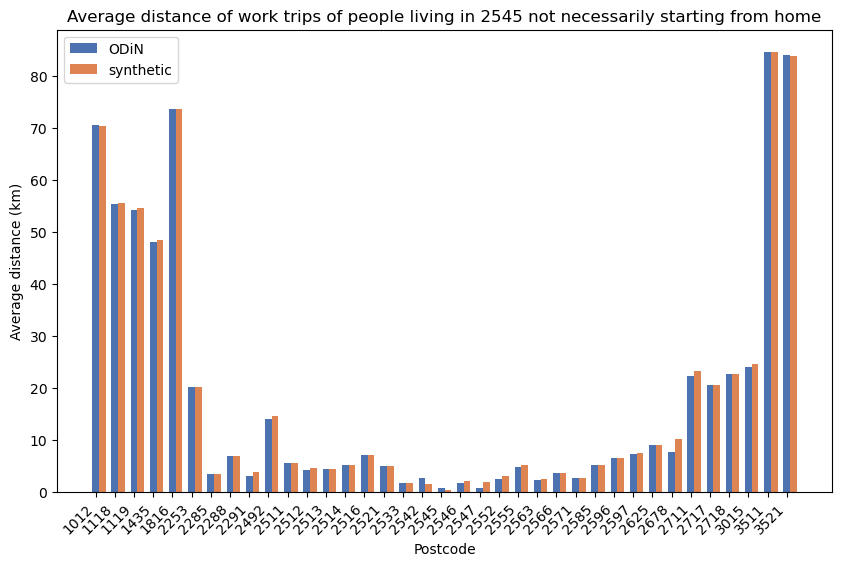

In [38]:
def distance_distribution(df_ODiN, df_synthetic):
    df_ODiN[['disp_arrival_PC4', 'euclidean_distance']]
    average_distances_ODiN = df_ODiN.groupby('disp_arrival_PC4').agg({'euclidean_distance': 'mean'}).reset_index()
    average_distances_synthetic = df_synthetic.groupby('disp_arrival_PC4').agg({'euclidean_distance': 'mean'}).reset_index()
    
    df_merged = pd.merge(average_distances_ODiN, average_distances_synthetic, on='disp_arrival_PC4', suffixes=('_ODiN', '_synthetic'))
    df_merged = df_merged.sort_values('disp_arrival_PC4')
    
    plt.figure(figsize=(10, 6))
    
    bar_width = 0.35
    bar_positions1 = np.arange(len(df_merged))
    bar_positions2 = bar_positions1 + bar_width
    
    plt.bar(bar_positions1, df_merged['euclidean_distance_ODiN'], width=bar_width, label='ODiN')
    plt.bar(bar_positions2, df_merged['euclidean_distance_synthetic'], width=bar_width, label='synthetic')
    
    plt.xticks(bar_positions1, df_merged['disp_arrival_PC4'], rotation=45, ha='right')
    plt.xlabel('Postcode')
    plt.ylabel('Average distance (km)')
    plt.title('Average distance of work trips of people living in ' + postcode_analysis + ' not necessarily starting from home')
    
    plt.legend()
    plt.show()
    
distance_distribution(df_ODiN_filtered, df_synthetic_filtered)